# QGS model: Atmospheric model with heat exchange

## Li et al. 2017 model version

This model version is a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley) , with a radiative and heat exchanges scheme inspired by the MAOOAM model.

More detail can be found in the articles:
* Li, D., He, Y., Huang, J., Bi, L., & Ding, L. (2018). *Multiple equilibria in a land–atmosphere coupled system.* Journal of Meteorological Research, **32**(6), 950-973.
[doi:10.1007/s13351-018-8012-y](https://doi.org/10.1007/s13351-018-8012-y)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation.

## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [4]:
np.random.seed(210217)

Importing the model's modules

In [5]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

In [7]:
import pickle
# loading the model
with open('model.pickle', "rb") as file:
    model0 = pickle.load(file)

f0 = model0['f']
model_parameters0 = model0['parameters']
# Printing the model's parameters
model_parameters0.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.2777777777777778    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 99.0  [W][m^-2]  (spectral component 1 of the short-wave rad

/home/scratch01/gmiloshe/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


## Systems definition

General parameters

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

Setting some model parameters

In [9]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'n':1.5})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Same modes for the ground temperature modes
model_parameters.set_ground_channel_fourier_modes()

# Changing (increasing) the orography depth
model_parameters.ground_params.set_orography(0.2, 1)
# Setting the parameters of the heat transfer from the soil
model_parameters.gotemperature_params.set_params({'gamma': 1.6e7})
model_parameters.atemperature_params.set_params({ 'hlambda': 10.})


In [12]:
model_parameters.atemperature_params.set_insolation(300*0.33, 0)
model_parameters.gotemperature_params.set_insolation(300, 0)
# Printing the model's parameters
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.2777777777777778    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 99.0  [W][m^-2]  (spectral component 1 of the short-wave rad

Creating the tendencies function

In [13]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 11.7 s, sys: 763 ms, total: 12.5 s
Wall time: 12.4 s


In [15]:
import pickle

# saving the model
model={'f': f, 'Df': Df, 'parameters': model_parameters}

with open('model.pickle', "wb") as file:
    pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

## Time integration

Defining an integrator

In [14]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [15]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 46.6 ms, sys: 67.4 ms, total: 114 ms
Wall time: 18.7 s


Now integrate to obtain a trajectory on the attractor

In [16]:
%%time
integrator.integrate(0., 200000., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

CPU times: user 102 ms, sys: 129 ms, total: 230 ms
Wall time: 17.4 s


In [17]:
len(time), len(traj), traj.shape

(400001, 30, (30, 400001))

Names of variables:

In [18]:
model_parameters.latex_var_string

['{\\psi_{\\rm a,1}}',
 '{\\psi_{\\rm a,2}}',
 '{\\psi_{\\rm a,3}}',
 '{\\psi_{\\rm a,4}}',
 '{\\psi_{\\rm a,5}}',
 '{\\psi_{\\rm a,6}}',
 '{\\psi_{\\rm a,7}}',
 '{\\psi_{\\rm a,8}}',
 '{\\psi_{\\rm a,9}}',
 '{\\psi_{\\rm a,10}}',
 '{\\theta_{\\rm a,1}}',
 '{\\theta_{\\rm a,2}}',
 '{\\theta_{\\rm a,3}}',
 '{\\theta_{\\rm a,4}}',
 '{\\theta_{\\rm a,5}}',
 '{\\theta_{\\rm a,6}}',
 '{\\theta_{\\rm a,7}}',
 '{\\theta_{\\rm a,8}}',
 '{\\theta_{\\rm a,9}}',
 '{\\theta_{\\rm a,10}}',
 '{\\theta_{\\rm g,1}}',
 '{\\theta_{\\rm g,2}}',
 '{\\theta_{\\rm g,3}}',
 '{\\theta_{\\rm g,4}}',
 '{\\theta_{\\rm g,5}}',
 '{\\theta_{\\rm g,6}}',
 '{\\theta_{\\rm g,7}}',
 '{\\theta_{\\rm g,8}}',
 '{\\theta_{\\rm g,9}}',
 '{\\theta_{\\rm g,10}}']

/tmp/ipykernel_28047/2034927038.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axi = fig.gca(projection='3d')


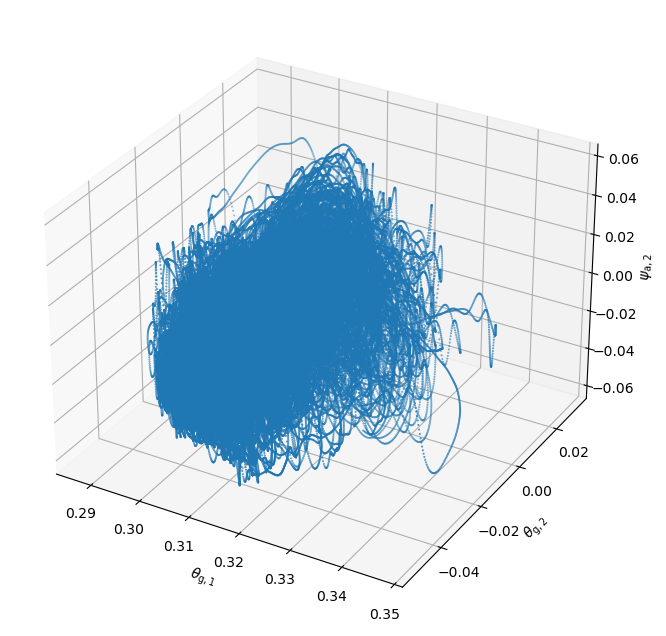

In [16]:
varx = 20
vary = 21
varz = 1

fig = plt.figure(figsize=(10, 8))
axi = fig.gca(projection='3d')

axi.scatter(traj[varx], traj[vary], traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

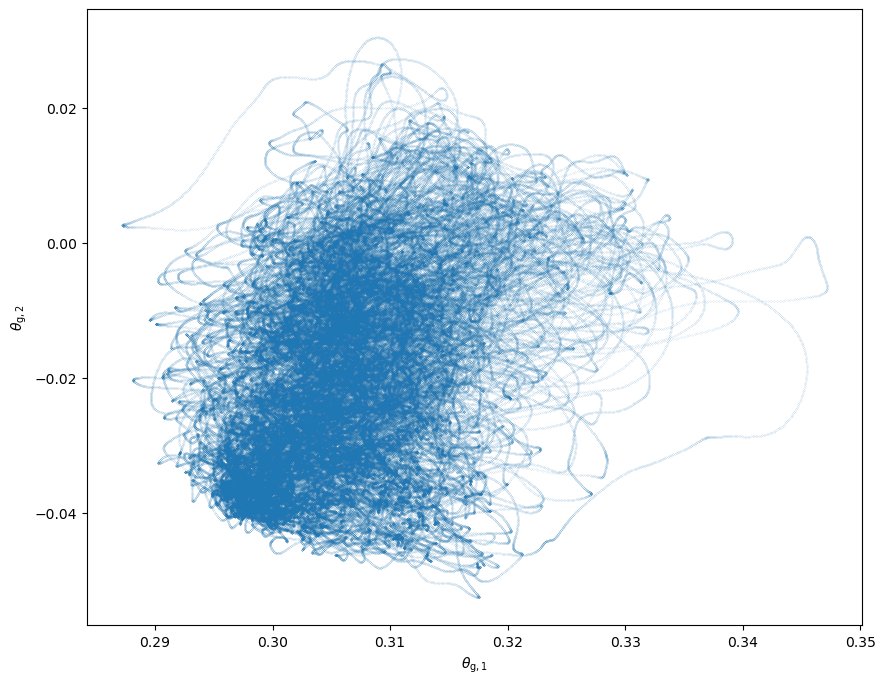

In [17]:
varx = 20
vary = 21
plt.figure(figsize=(10, 8))

plt.plot(traj[varx], traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

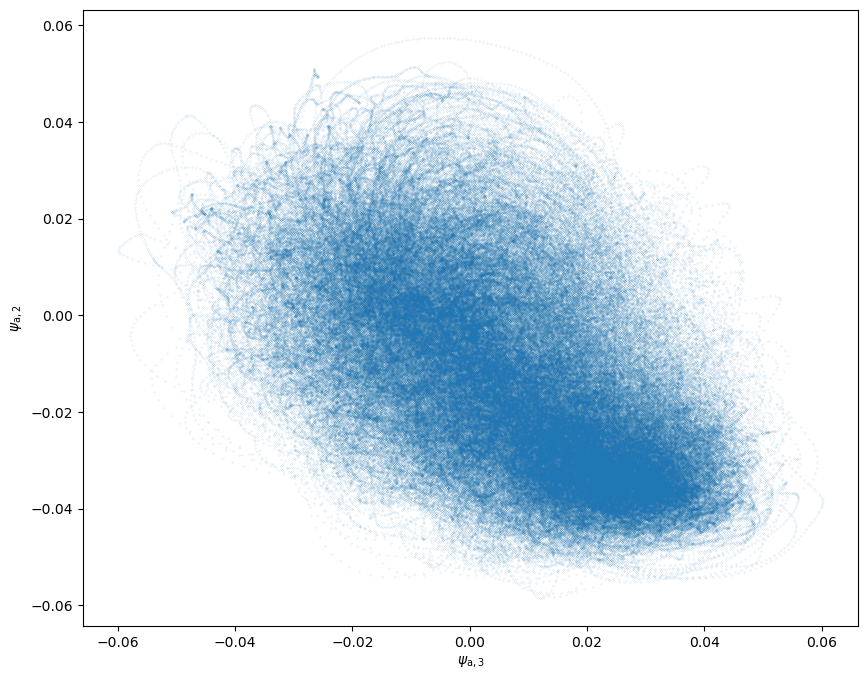

In [18]:
varx = 2
vary = 1
plt.figure(figsize=(10, 8))

plt.plot(traj[varx], traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

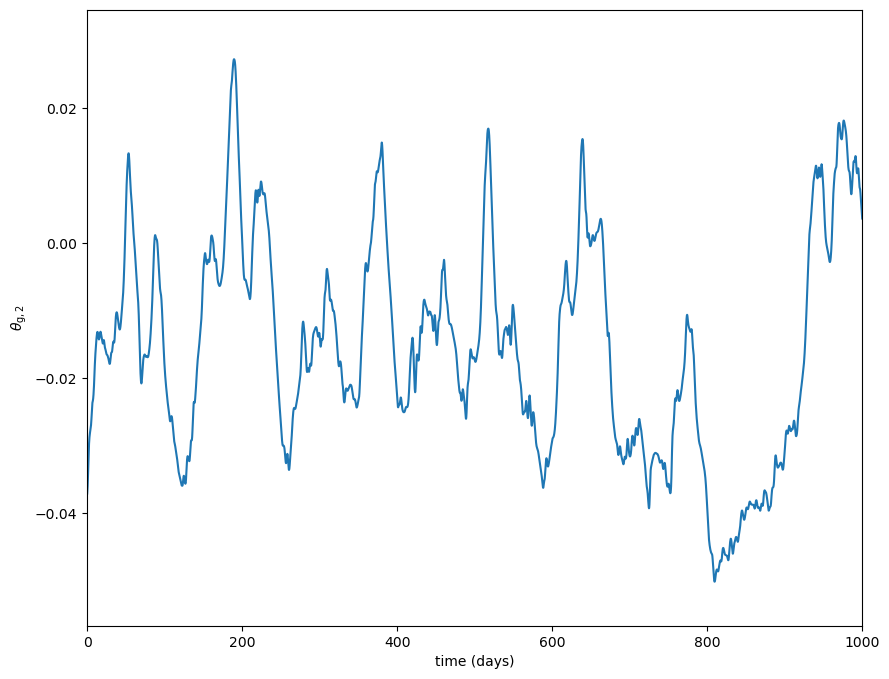

In [20]:
var = 21
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

plt.xlim(0.,1000.)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

In [21]:
len(model_parameters.dimensional_time*time), len(traj[var])

(400001, 400001)

## Initial condition sensitivity analysis example

Instantiating a tangent linear integrator with the model tendencies

In [22]:
tgls_integrator = RungeKuttaTglsIntegrator()

In [23]:
tgls_integrator.set_func(f, Df)

Integrating with slightly perturbed initial conditions

In [26]:
print(f"{number_of_perturbed_trajectories = }, {model_parameters.ndim = }")
tangent_ic = 0.00001*np.random.randn(number_of_perturbed_trajectories, model_parameters.ndim)
print(f"{tangent_ic.shape = }, for example {tangent_ic[0,0] = }")

number_of_perturbed_trajectories = 10, model_parameters.ndim = 30
tangent_ic.shape = (10, 30), for example tangent_ic[0,0] = -1.5787524545833062e-05


Below we will re-use the initial conditions that are already relaxed on the attractor

In [27]:
%%time 
print(f"{write_steps = }")
tgls_integrator.integrate(0., 2000., dt=dt, write_steps=write_steps, ic=ic, tg_ic=tangent_ic)

/home/scratch01/gmiloshe/qgs/qgs/integrators/integrate.py:601: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  hom = inverse * _tangent_linear_system(fjac, tt + c[i] * dt, y_s, km_s, adjoint)
/home/scratch01/gmiloshe/qgs/qgs/integrators/integrate.py:601: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  hom = inverse * _tangent_linear_system(fjac, tt + c[i] * dt, y_s, km_s, adjoint)


CPU times: user 17.6 ms, sys: 40.3 ms, total: 57.9 ms
Wall time: 6.88 s


Obtaining the perturbed trajectories

In [30]:
tt, traj, delta = tgls_integrator.get_trajectories()

In [31]:
pert_traj = traj + delta

In [34]:
len(model_parameters.dimensional_time*tt), len(traj[var])

(4001, 4001)

Trajectories plot

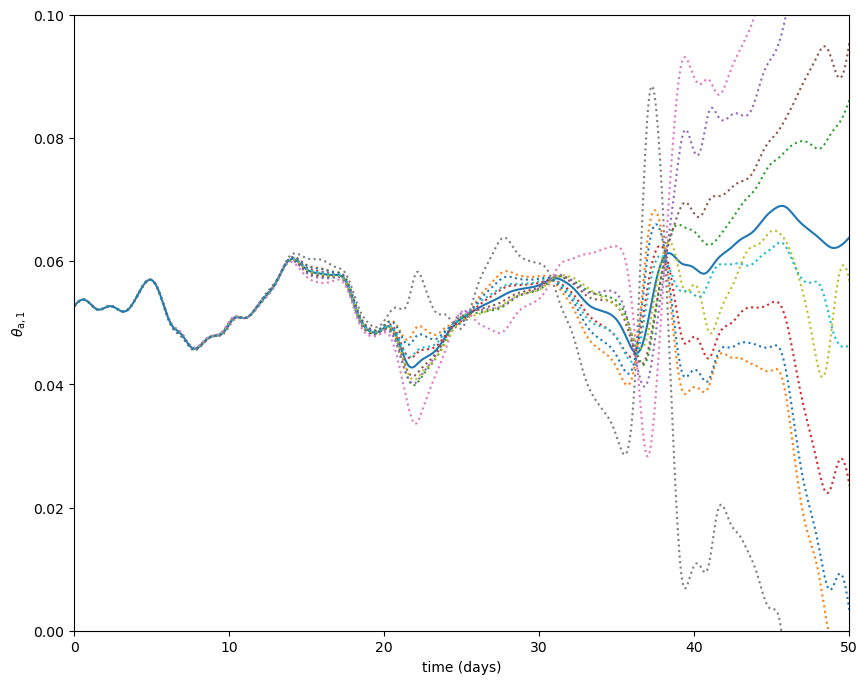

In [32]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])
plt.plot(model_parameters.dimensional_time*tt, pert_traj[:,var].T, ls=':')

ax = plt.gca()

plt.ylim(0.,0.1)
plt.xlim(0.,50.)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

Mean and standard deviation

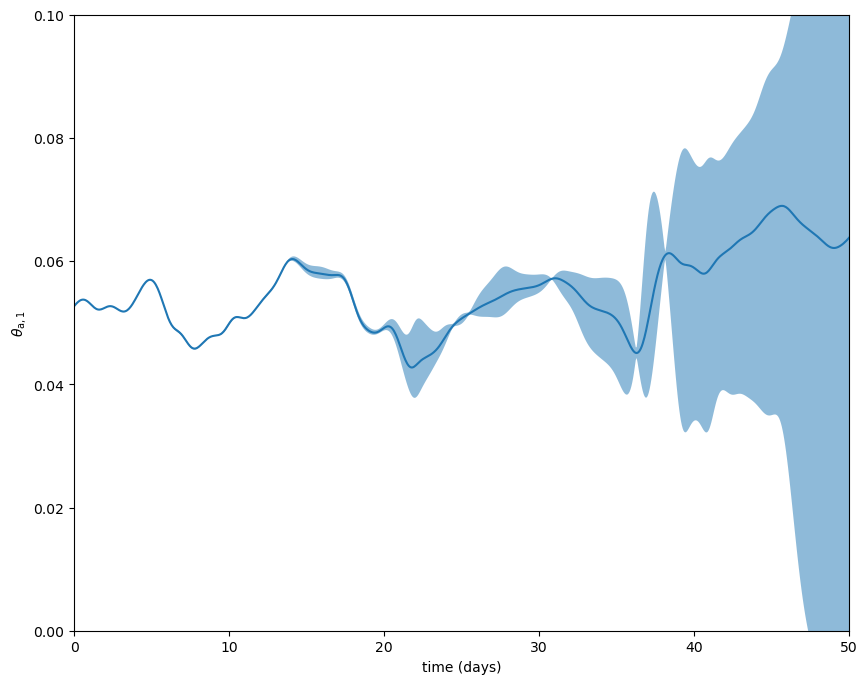

In [33]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])

ax = plt.gca()
std_plot(model_parameters.dimensional_time*tt, np.mean(pert_traj[:,var], axis=0), np.sqrt(np.var(pert_traj[:, var], axis=0)), ax=ax, alpha=0.5)
plt.ylim(0.,0.1)
plt.xlim(0.,50.)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');